In [2]:
from util import setup_notebook
setup_notebook()
%load_ext autoreload
%autoreload 2

In [3]:
import altair as alt
import pandas as pd

In [4]:
from testmining.loader import read_dump
data = read_dump('../travistorrent_8_2_2017.csv')

In [5]:
from testmining.builds import build_statistics

In [6]:
builds = build_statistics(data)
builds.head()

,gh_project_name,gh_pull_req_num,gh_is_pr,test_failures,tr_duration,tr_log_testduration,tr_log_buildduration
tr_build_id,,,,,,,
106060,rails/rails,NaN,False,False,156165.0,0.00,0.0
106176,rails/rails,NaN,False,False,185910.0,0.00,0.0
106236,intridea/omniauth,NaN,False,False,6210.0,8.24,0.0
106306,myronmarston/vcr,NaN,False,False,5952.0,283.81,0.0
106359,intridea/omniauth,NaN,False,False,5418.0,7.59,0.0


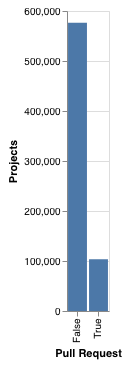

In [7]:
import altair as alt
alt.data_transformers.enable('csv')
alt.Chart(builds).mark_bar().encode(
    x=alt.X('gh_is_pr', title='Pull Request'),
    y=alt.Y('count()', title='Projects'))

In [8]:
# How many builds have test failures?
test_failure_count = builds['test_failures'].sum()
relative_test_failure_count = test_failure_count / len(builds)

from IPython.display import display
display('Test failure rate: %f' % relative_test_failure_count)
display('Test failures: %d' % test_failure_count)

'Test failure rate: 0.116058'

'Test failures: 78944'

In [97]:
# On average, how much time is spent on testing?
# Insight: if there are test failures, test time bumps up to 48% on average.
has_valid_duration = \
    (builds['tr_log_testduration'] > 0) & \
    (builds['tr_log_buildduration'] >  0) & \
    (builds['tr_log_testduration'] < builds['tr_log_buildduration'])

display('%d builds have conclusive test and build duration (of %d builds)' % (has_valid_duration.sum(), len(builds)))

average_time_spent = (builds[has_valid_duration]['tr_log_testduration'] / builds[has_valid_duration]['tr_log_buildduration']).mean()
display('On average, %f * buildtime is spent on testing for builds with reliable duration information' % average_time_spent)

'56066 builds have conclusive test and build duration (of 680209 builds)'

'On average, 0.399072 * buildtime is spent on testing for builds with reliable duration information'

In [67]:
# How long does a project build on average?
unreliable_avg_testduration_hours = builds['tr_log_testduration'].mean() / 60 / 60
display('With noisy timing information, average test duration is %.2f hours' % unreliable_avg_testduration_hours)

valid_test_durations = builds[has_valid_duration][['tr_log_testduration']]
avg_testduration_minutes = valid_test_durations.mean() / 60
display('With reasonable timing information, average test duration is %.2f minutes' % avg_testduration_minutes[0])

'With noisy timing information, average test duration is 4.88 hours'

'With reasonable timing information, average test duration is 5.59 minutes'

In [68]:
# Terrible: 15 years of test runtime?
display(builds.loc[builds['tr_log_testduration'].idxmax()])
display(builds['tr_log_testduration'].max() / 60 / 60 / 24 / 365)

gh_project_name         rails/rails
gh_pull_req_num                 NaN
gh_is_pr                      False
test_failures                  True
tr_duration                    9280
tr_log_testduration     4.86805e+08
tr_log_buildduration              0
Name: 65543785, dtype: object

15.436489166032468

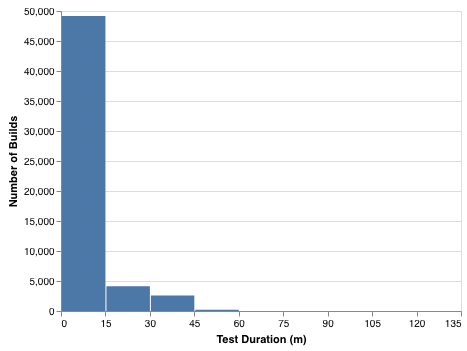

In [71]:
# FIXME maybe redo these charts - they evaluate the 'logical time', if all jobs of a build were run sequentially, and the time adds up.
# Maybe do another version with the max job time of a build.
# Given the noisy timing data, it might not be worth the effort.

# Researching the 15 minute build myth
alt.Chart(valid_test_durations / 60).mark_bar().encode(
  x=alt.X('tr_log_testduration', bin=alt.BinParams(step=15), title='Test Duration (m)'),
  y=alt.Y('count()', title='Number of Builds'))

In [100]:
# Grains of salt
# 12% of builds *test* longer than 15 minutes, which is on average 30m test time
# 55% of builes *run* longer than 15 minutes, which results on average in 9m test time. 

#build15_violators = (valid_test_durations > (15 * 60))
build15_violators = (builds[has_valid_duration]['tr_duration'] > (15 * 60))
share_build15 = build15_violators.sum() / len(build15_violators) * 100
display('%.2f %% of builds exceed the 15 minute build rule' % share_build15)
build15_violator_avg = valid_test_durations[build15_violators].mean() / 60
display('If 15m is exceeded anyway, the avg is %.2f m' % build15_violator_avg)

'54.88 % of builds exceed the 15 minute build rule'

'If 15m is exceeded anyway, the avg is 9.06 m'

In [98]:
((valid_test_durations >= 15 * 60) & (valid_test_durations <= 60 * 60)).sum()

tr_log_testduration    6893
dtype: int64

In [9]:
# How many builds are there per project on average?
builds.groupby('gh_project_name').agg('size').mean()

530.1706936866718

In [10]:
# How many builds were part of a PR?
builds['gh_is_pr'].sum() / len(builds)

0.15225320452978422

In [11]:
pr_builds = builds[builds['gh_is_pr']]
build_counts = pr_builds.groupby('gh_project_name').agg('size')

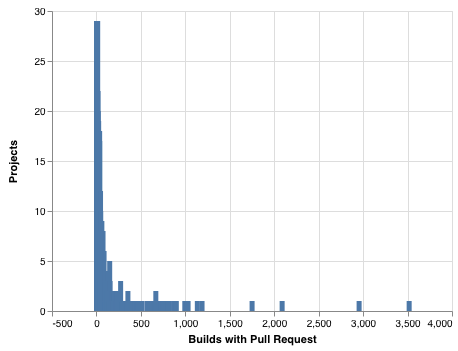

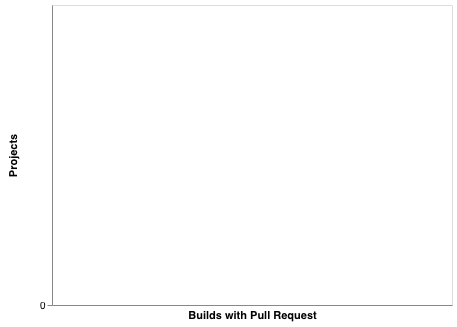

In [12]:
build_counts_df = pd.DataFrame({'build_count': build_counts})
alt.Chart(build_counts_df).mark_bar().encode(
    x=alt.X('build_count', title='Builds with Pull Request'),
    y=alt.Y('count()', title='Projects'))